In [54]:
import os
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats
import matplotlib
from matplotlib import pyplot as plt
import Karlo.model.transformer as transformer
import torch
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator


def sigzi(x, axis=None):
    return 0.741 * (np.percentile(x, 75, axis=axis) - np.percentile(x, 25, axis=axis))

def density_color_mask(x, y, small_size):
    x = np.array(x)
    y = np.array(y)
    xy = (np.vstack([x.ravel(), y.ravel()]))
    if x.shape[0] > small_size:
        small_sample = np.random.choice(range(x.shape[0]), size=small_size)
        z = gaussian_kde(xy[:, small_sample], bw_method='silverman')(xy)
    else:
        z = gaussian_kde(xy, bw_method='silverman')(xy)
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x, y, z


def plot_correlation(true, prediction, axis, name="", small_size=15000, true_name="true", limit=None):
    if type(true) is tuple or type(true) is list:
        cmaps = ['Purples', 'Greens', 'Reds', 'Blues', 'Oranges', 'YlOrBr',
                 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu',
                 'PuBuGn', 'BuGn', 'YlGn']
        axis.set_xlabel(xlabel=true_name)
        axis.set_ylabel(ylabel="NN estimated")
        if limit is None:
            limit = (true[0].min(), true[0].max())
        if (type(name) is not list) and (type(name) is not tuple or len(name) == 1):
            name = [str(i) for i in range(len(true))]
        for i in range(len(true)):
            limit = (min(limit[0], min(true[i].min(), prediction[i].min())),
                     max(limit[1], max(true[i].max(), prediction[i].max())))
            t, p, z = density_color_mask(true[i], prediction[i], small_size)
            axis.scatter(np.array(t).flatten(),
                         np.array(p).flatten(),
                         c=z, label=name[i], s=1, cmap=cmaps[i])
    else:
        cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
        axis.set_xlabel(xlabel=name + " " + true_name)
        axis.set_ylabel(ylabel=name + " NN estimated")
        if limit is None:
            limit = (min(true.min(), prediction.min()),
                    max(true.max(), prediction.max()))
        t, p, z = density_color_mask(true, prediction, small_size)
        scatter=axis.scatter(np.array(t).flatten(),
                             np.array(p).flatten(),
                             c=z, label=name, s=1, cmap=cmaps[0])
        cbar = plt.colorbar(scatter, ax=axis, pad=0.02)
        cbar.ax.set_ylabel("Points Density", rotation=270, labelpad=-15)
        cbar.set_ticks([z.min(), z.max()])
        cbar.set_ticklabels(['low', 'high'])
    axis.plot([limit[0], limit[1]], [limit[0], limit[1]], c='red', linestyle="dashed", alpha=0.9)
    lgnd = axis.legend(scatterpoints=1, loc='lower right')
    axis.set_facecolor("white")
    limit = (limit[0] - 0.05 * (limit[1] - limit[0]), limit[1] + 0.05 * (limit[1] - limit[0]))
    axis.set(xlim=limit, ylim=limit)
    for i, handle in enumerate(lgnd.legend_handles[0:-1]):
        handle.set_sizes([10.0])
        handle.set_color(matplotlib.cm.get_cmap(cmaps[i])(0.7))
    return axis

def plot_expected_gauss(p, sigma_p, y_test, outputs, ax, mask=None, nbins=300, true_name="true"):
    if mask is not None:
        p = [p[i][mask] for i in range(len(p))]
        sigma_p = [sigma_p[i][mask] for i in range(len(sigma_p))]
        y_test = [y_test[i][mask] for i in range(len(y_test))]
    ax.set_xlabel(
            r"$\frac{" + outputs + "_{NN} - " + outputs + "_{" + true_name + "}}{ \sigma_{" + outputs + "} }$")
    ax.set_yticks([])
    points_norm = (p[sigma_p != 0] - y_test[sigma_p != 0]) / sigma_p[sigma_p != 0]
    points_norm = points_norm[(points_norm > -5 * sigzi(points_norm)) &
                                  (points_norm < 5 * sigzi(points_norm))]
    hist, bins = np.histogram(points_norm, bins=nbins)
    ax.bar(bins[:-1], hist, width=np.diff(bins))
    norm_x = np.linspace(-5 * sigzi(points_norm), 5 * sigzi(points_norm), 100)
    #norm_x = np.linspace(np.min(points_norm), np.max(points_norm), 100)
    norm_y = scipy.stats.norm.pdf(norm_x, 0, 1) * points_norm.shape[0] * np.diff(bins)[0]
    ax.plot(norm_x, norm_y, color="red", label="N(0,1)")
    ax.legend(loc="upper right")
    return ax

def residual_histogram (y, p, ax, nbins=100, x_label=r"$E^{qg}_{NN} - E^{qg}_{true}$"):
    residual = y - p
    residual = residual[(residual > -5 * sigzi(residual)) & (residual < 5 * sigzi(residual))]
    hist, bins = np.histogram(residual, bins=nbins)
    ax.bar(bins[:-1], hist, width=np.diff(bins))
    norm_x = np.linspace(-5 * sigzi(residual), 5 * sigzi(residual), nbins)
    norm_y = scipy.stats.norm.pdf(norm_x, 0, sigzi(residual)) * residual.shape[0] * np.diff(bins)[0]
    ax.plot(norm_x, norm_y, color="red", label="N(0,"+str(round(sigzi(residual),1))+")")
    ax.legend(loc="upper right")
    ax.set_xlabel(x_label)
    ax.set_yticks([])
    return ax

def plot_2d_map(x, y, ax, xname="", yname="", subsample=3000):
    cmaps = 'Blues'
    ax.set_xlabel(xlabel=xname)
    ax.set_ylabel(ylabel=yname)
    x_s, y_s, z = density_color_mask(x, y, subsample)

    # plotting the points with color
    im = ax.scatter(np.array(x_s).flatten(),
                      np.array(y_s).flatten(),
                      c=z, s=1, cmap=cmaps)
    ax.set_facecolor("white")
    cb = plt.colorbar(im, ticks=[])
    cb.set_label("density on linear scale")
    return ax

def fit_medians(x, y, x_min, x_max, n_bin, min_points_for_median=1):
    # first generate bins
    x_edge = np.linspace(x_min, x_max, (n_bin + 1))
    x_bin = np.linspace(0, 1, n_bin)
    n_pts = 0 * np.linspace(0, 1, n_bin)
    median_bin = 0 * np.linspace(0, 1, n_bin)
    sig_gbin = -1 + 0 * np.linspace(0, 1, n_bin)
    for i in range(0, n_bin):
        x_bin[i] = 0.5 * (x_edge[i] + x_edge[i + 1])
        y_aux = y[(x > x_edge[i]) & (x <= x_edge[i + 1])]
        if y_aux.size > 0:
            n_pts[i] = y_aux.size
            median_bin[i] = np.median(y_aux)
            # robust estimate of standard deviation: 0.741*(q75-q25)
            sigma_g = 0.741 * (np.percentile(y_aux, 75) - np.percentile(y_aux, 25))
            # uncertainty of the median: sqrt(pi/2)*st.dev/sqrt(n)
            #sig_gbin[i] = np.sqrt(np.pi / 2) * sigma_g / np.sqrt(n_pts[i])
            sig_gbin[i] = sigma_g
        else:
            n_pts[i] = y_aux.size
            median_bin[i] = np.nan
            sig_gbin[i] = np.nan
    x_bin = x_bin[n_pts > min_points_for_median]
    median_bin = median_bin[n_pts > min_points_for_median]
    sig_gbin = sig_gbin[n_pts > min_points_for_median]
    return x_bin, median_bin, sig_gbin


def plot_medians_on_2d_map(x, y, axis, error_type="line", zero_line=True):
    xlimit = axis.get_xlim()
    x_bin, median_bin, sig_gbin = fit_medians(x, y, xlimit[0], xlimit[1], 60)
    if zero_line:
        axis.plot([xlimit[0], xlimit[1]], [0, 0], c='black', linestyle="dashed", alpha=0.2)
    if error_type == "bar":
        axis.errorbar(x_bin, median_bin, yerr=sig_gbin, c='red', xerr=None, linestyle='', marker=".", markersize=2,
                      label="Median")
    elif error_type == "line":
        #axis.scatter(x_bin, median_bin, c="red", s=2, label="Median")
        axis.plot(x_bin, median_bin, c="red", linestyle='solid', alpha=0.9, label="Median")
        axis.plot(x_bin, median_bin+sig_gbin, c="red", linestyle='dashed', alpha=0.9)
        axis.plot(x_bin, median_bin - sig_gbin, c="red", linestyle='dashed', alpha=0.9)
    else:
        raise ValueError("error_type should be 'bar' or 'line'")
    __ = axis.legend(loc="lower left")
    return axis

def coverage_plot(y, p, ax, bins=20):
    bins = np.linspace(y.min(), y.max(), bins)
    hist, bins = np.histogram(y, bins=bins)
    hist_c, bins = np.histogram(y[np.abs(y-p[:, 0])<p[:, 1]], bins=bins)
    coverage = hist_c / hist
    ax.hlines(0.6826894, bins[0], bins[-1], colors='black', linestyles='dashed', label="$1 \sigma$")
    ax.plot(bins[1:]-np.diff(bins), coverage, label="NN")
    ax.set_xlabel(r"$E^{qg}_{true}$")
    ax.set_ylabel(r"coverage")
    ax.legend()

In [3]:
x_test, y_test = np.load("./Karlo/extra/trainset_p2000n2500_test.npz").values()

model = transformer.LIVTransformer()
intrinsic_lightcurve = y_test[:, 2:8]
intrinsic_spectrum = y_test[:, :2]
y_test = np.log10(y_test[:, -1])
model.load_state_dict(torch.load("./Karlo/extra/transformer55.pt"))
prediction = model.predict(x_test)

/home/karlo/miniconda3/envs/liv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


<Axes: xlabel='$E^{qg}$ true', ylabel='$E^{qg}$ NN estimated'>

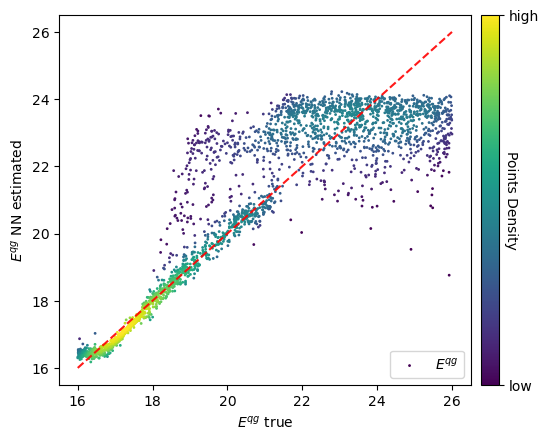

In [9]:
fig, ax = plt.subplots()
plot_correlation(y_test, prediction[:,0], ax, name="$E^{qg}$")

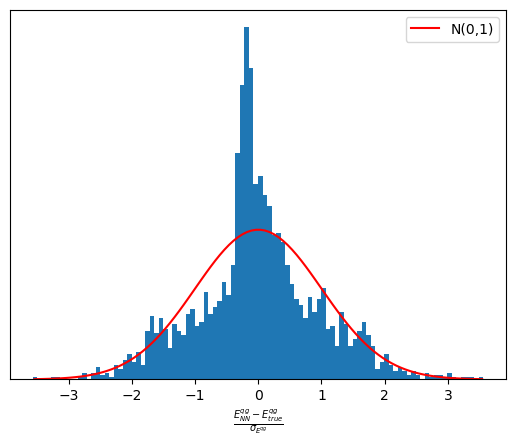

In [11]:
fig, ax = plt.subplots()
ax = plot_expected_gauss(prediction[:, 0], prediction[:, 1], y_test, "E^{qg}", ax,
                                   mask=None, nbins=100, true_name="true")

<Axes: xlabel='$E^{qg}_{NN} - E^{qg}_{true}$'>

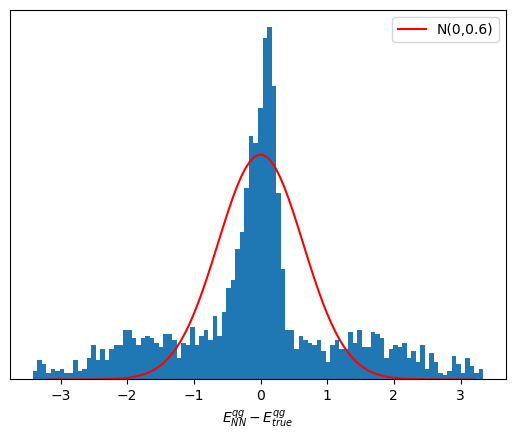

In [18]:
fig, ax = plt.subplots()
residual_histogram(y_test, prediction[:, 0], ax)

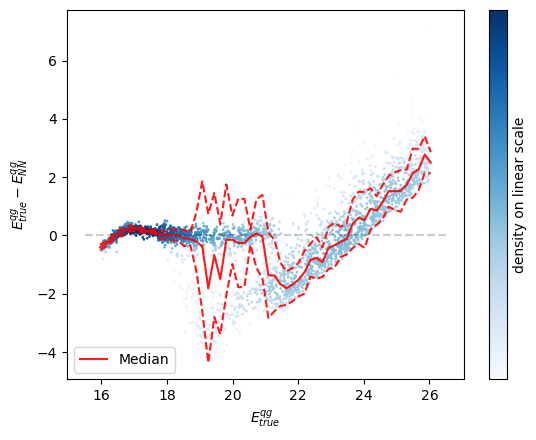

In [12]:
fig, ax = plt.subplots()
ax = plot_2d_map(y_test, y_test-prediction[:, 0], ax, xname="$E^{qg}_{true}$", yname="$E^{qg}_{true} - E^{qg}_{NN}$")
ax = plot_medians_on_2d_map(y_test, y_test-prediction[:, 0], ax, error_type="line")

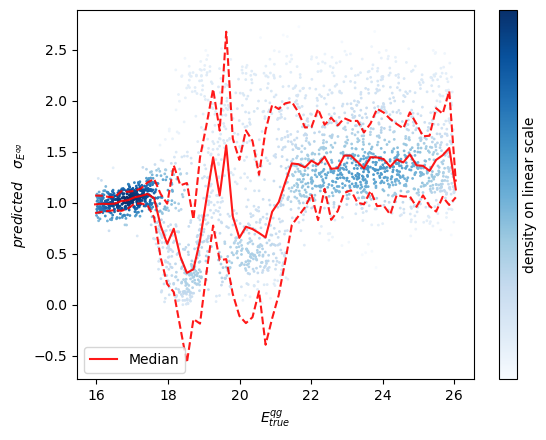

In [13]:
fig, ax = plt.subplots()
ax = plot_2d_map(y_test, prediction[:, 1], ax, xname="$E^{qg}_{true}$", yname="$predicted \quad \sigma_{E^{qg}}$")
ax = plot_medians_on_2d_map(y_test, prediction[:, 1], ax, error_type="line", zero_line=False)

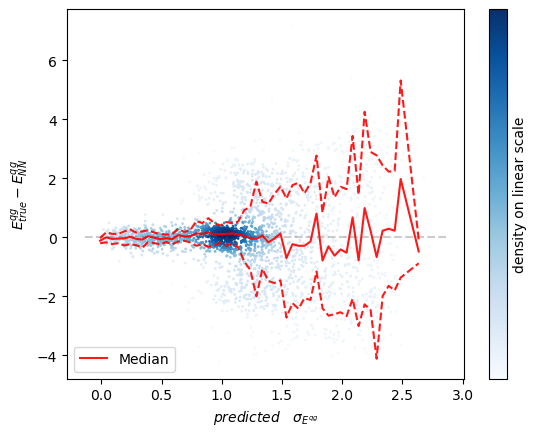

In [14]:
fig, ax = plt.subplots()
ax = plot_2d_map(prediction[:, 1], y_test-prediction[:, 0], ax, xname="$predicted \quad \sigma_{E^{qg}}$", yname="$E^{qg}_{true} - E^{qg}_{NN}$")
ax = plot_medians_on_2d_map(prediction[:, 1], y_test-prediction[:, 0], ax, error_type="line")

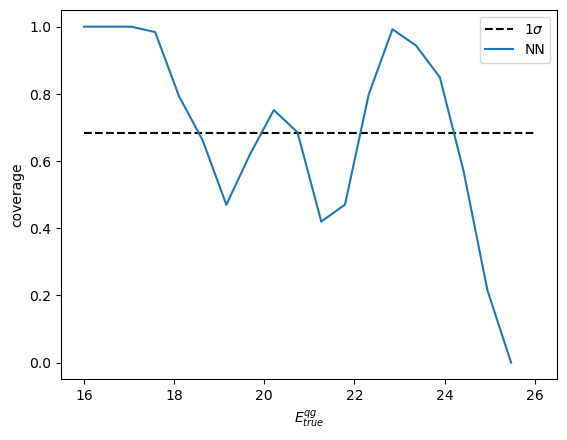

In [55]:
fig, ax = plt.subplots()
coverage_plot(y_test, prediction, ax)

In [57]:
print ("Total coverage is: " + str(np.sum(np.abs(y_test-prediction[:, 0])<prediction[:, 1])/(y_test.shape[0])))

Total coverage is: 0.7056
